In [ ]:
import scipy.io
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import os

import math

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install tensorboard_logger

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorboard_logger as tb_logger
import torch.backends.cudnn as cudnn
import sys
import time

In [ ]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")

In [ ]:
dataset = ['India', 'Pavia'][1]
random_split = False
use_cnn_1d = False

In [ ]:
if dataset == 'India':
    raw_data = scipy.io.loadmat('./drive/MyDrive/HSI-datasets/indian_pines_corrected.mat')
    disjoint_data = scipy.io.loadmat(os.getcwd() + '/drive/MyDrive/HSI-datasets/indianpines_disjoint_dset.mat')
    all_labels = scipy.io.loadmat(os.getcwd() + '/drive/MyDrive/HSI-datasets/indian_pines_gt.mat')

    X = raw_data['indian_pines_corrected']
    y_disjoint = disjoint_data['indianpines_disjoint_dset']
    y_all = all_labels['indian_pines_gt']

    test_ratio = 0.45
else:
    raw_data = scipy.io.loadmat('./drive/MyDrive/HSI-datasets/paviaU.mat')
    disjoint_data = scipy.io.loadmat(os.getcwd() + '/drive/MyDrive/HSI-datasets/TRpavia_fixed.mat')
    all_labels = scipy.io.loadmat(os.getcwd() + '/drive/MyDrive/HSI-datasets/paviaU_gt.mat')

    X = raw_data['paviaU']
    y_disjoint = disjoint_data['TRpavia_fixed']
    y_all = all_labels['paviaU_gt']

    test_ratio = 0.93

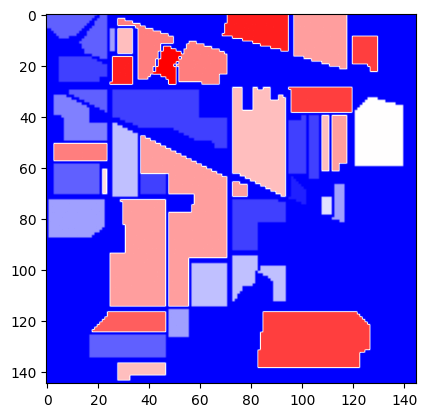

In [ ]:
# Plot the grid
plt.imshow(y_all, cmap='bwr')
plt.show()

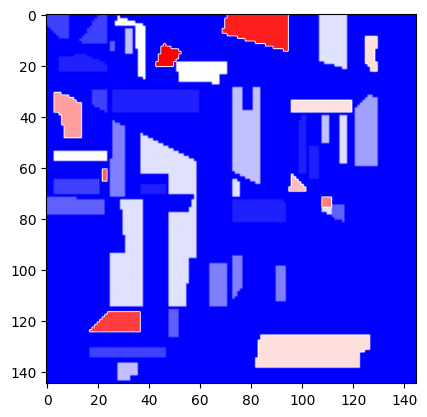

In [ ]:
# Plot the grid
plt.imshow(y_disjoint, cmap='bwr')
plt.show()

In [ ]:
import scipy.io
import numpy as np
import copy
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# -*- coding: utf-8 -*-
# Torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.nn import init
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
num_channels = X.shape[-1]
W = X.shape[0]
H = X.shape[1]

In [ ]:
X = X.reshape(W*H, num_channels)
y_all = y_all.reshape(-1, 1).flatten()
y_disjoint = y_disjoint.reshape(-1, 1).flatten()

X = X.astype(np.float32)
y = y_all.astype(np.int16)

In [ ]:
X.shape

(207400, 103)

In [ ]:
if random_split:
    nonzero_idx = np.where(y != 0)
    X = X[nonzero_idx]
    y = y[nonzero_idx]
    y = y - 1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
else:
    train_idx = np.where((y_disjoint != 0) & (y_all != 0))
    X_train = X[train_idx]
    y_train = y[train_idx]

    test_idx = np.where((y_disjoint == 0) & (y_all != 0))
    X_test = X[test_idx]
    y_test = y[test_idx]

    y_train -= 1
    y_test -= 1

    print('Disjoint')

Disjoint


In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=200, min_samples_split=3, max_features=10, max_depth=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6573975801316069


In [ ]:
from sklearn.svm import SVC

clf = SVC(C=100, gamma=0.125, tol=1e-7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7976351182440878


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', dual=False, tol=1e-20, C=1, \
                        solver='lbfgs', multi_class='multinomial', max_iter=5000,\
                        fit_intercept=True, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7463126843657817


In [ ]:
# Researve 10% validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
if use_cnn_1d:
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    X_train = np.transpose(X_train, (0, 2, 1))
    X_val = np.transpose(X_val, (0, 2, 1))
    X_test = np.transpose(X_test, (0, 2, 1))

In [ ]:
print(y_train.shape, y_test.shape)
print(X_train.shape, X_test.shape)

(2496,) (40002,)
(2496, 103) (40002, 103)


In [ ]:
tensor_x = torch.Tensor(X_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train)
tensor_y = tensor_y.type(torch.LongTensor)

train_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=100) # create your dataloader

In [ ]:
tensor_x = torch.Tensor(X_val) # transform to torch tensor
tensor_y = torch.Tensor(y_val)
tensor_y = tensor_y.type(torch.LongTensor)

val_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
val_dataloader = DataLoader(val_dataset, batch_size=100) # create your dataloader

In [ ]:
tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.Tensor(y_test)
tensor_y = tensor_y.type(torch.LongTensor)

test_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=100) # create your dataloader

In [ ]:
save_freq = 40
print_freq = 100

learning_rate = 1e-3
num_classes = len(np.unique(y_train))

In [ ]:
class fnn(nn.Module):
    """
    Baseline network
    """

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm1d):
            m.weight.data.fill_(0.5)
            m.bias.data.zero_()

    def __init__(self, input_channels, n_classes):
        super(fnn, self).__init__()

        self.fc1 = nn.Linear(input_channels, 143)
        self.fc2 = nn.Linear(143, n_classes)

        self.apply(self.weight_init)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class recurrent(nn.Module):
    """
    Baseline network
    """

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            init.kaiming_normal_(m.weight)
            init.zeros_(m.bias)

    def __init__(self, input_channels, n_classes):
        super(recurrent, self).__init__()

        self.rnn1 = nn.LSTM(input_channels, 64, 1, batch_first=True)
        self.rnn2 = nn.LSTM(64, 64, 1, batch_first=True)
        self.fc = nn.Linear(64, n_classes)

        self.apply(self.weight_init)

    def forward(self, x):
        x, states = self.rnn1(x)
        x, states = self.rnn2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc(x)
        return x

In [ ]:
class cnn1d(nn.Module):
    """
    CNN1d network
    """

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm1d):
            m.weight.data.fill_(0.5)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

    def __init__(self, input_channels, n_classes):
        super(cnn1d, self).__init__()

        self.conv = nn.Conv1d(in_channels=1, out_channels=20, kernel_size=24, stride=1)
        self.pool = nn.MaxPool1d(5)

        self.fc1 = nn.Linear(700, 100)
        self.batch_norm = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, n_classes)

        self.apply(self.weight_init)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.batch_norm(self.fc1(x)))
        x = self.fc2(x)
        return x

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def validate(val_loader, model, criterion):
    """validation"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for idx, (input, target) in enumerate(val_loader):

            input = input.float()
            if torch.cuda.is_available():
                input = input.cuda()
                target = target.cuda()

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), input.size(0))
            top1.update(acc1[0], input.size(0))
            top5.update(acc5[0], input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if idx % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                      'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                       idx, len(val_loader), batch_time=batch_time, loss=losses,
                       top1=top1, top5=top5))

        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return top1.avg, top5.avg, losses.avg

In [ ]:
def train_vanilla(epoch, train_loader, model, criterion, optimizer):
    """vanilla training"""
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    end = time.time()
    for idx, (input, target) in enumerate(train_loader):
        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        output = model(input)
        loss = criterion(output, target)

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0], input.size(0))
        top5.update(acc5[0], input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()

        # tensorboard logger
        pass

        # print info
        if idx % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Acc@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   epoch, idx, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1, top5=top5))
            sys.stdout.flush()

    print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))

    return top1.avg, losses.avg

In [ ]:
def train_model(train_loader, val_loader, epochs):
    best_acc = 0

    # model
    if use_cnn_1d:
        model = cnn1d(num_channels, num_classes).to(device)
    else:
        model = fnn(num_channels, num_classes).to(device)

    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()

    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
        cudnn.benchmark = True

    # tensorboard
    logger = tb_logger.Logger(logdir="./model_tensorboard", flush_secs=2)

    # routine
    for epoch in range(1, epochs + 1):

        #adjust_learning_rate(epoch, opt, optimizer)
        print("==> training...")

        time1 = time.time()
        train_acc, train_loss = train_vanilla(epoch, train_loader, model, criterion, optimizer)
        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        logger.log_value('train_acc', train_acc, epoch)
        logger.log_value('train_loss', train_loss, epoch)

        test_acc, test_acc_top5, test_loss = validate(val_loader, model, criterion)

        logger.log_value('test_acc', test_acc, epoch)
        logger.log_value('test_acc_top5', test_acc_top5, epoch)
        logger.log_value('test_loss', test_loss, epoch)

        # save the best model
        if test_acc > best_acc:
            best_acc = test_acc
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'best_acc': best_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = './model_best.pth'
            print('saving the best model!')
            torch.save(state, save_file)

        # regular saving
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'accuracy': test_acc,
                'optimizer': optimizer.state_dict(),
            }
            save_file = os.path.join('./', 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

    # This best accuracy is only for printing purpose.
    # The results reported in the paper/README is from the last epoch.
    print('best accuracy:', best_acc)

    # save model
    state = {
        #'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    save_file = './model_last.pth'
    torch.save(state, save_file)

In [ ]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (MB):', size/1e6)
    os.remove('temp.p')
    return size

In [ ]:
def measure_inference_latency(model,
                              device,
                              input_size=(1, 40, 19, 19),
                              num_samples=100,
                              num_warmups=10):

    model.to(device)
    model.eval()

    x = torch.rand(size=input_size).to(device)

    with torch.no_grad():
        for _ in range(num_warmups):
            _ = model(x)
    torch.cuda.synchronize()

    with torch.no_grad():
        start_time = time.time()
        for _ in range(num_samples):
            _ = model(x)
            torch.cuda.synchronize()
        end_time = time.time()
    elapsed_time = end_time - start_time
    elapsed_time_ave = elapsed_time / num_samples

    return elapsed_time_ave

In [ ]:
train_model(train_dataloader, val_dataloader, epochs=200)

==> training...
Epoch: [1][0/25]	Time 0.008 (0.008)	Data 0.002 (0.002)	Loss 2.2021 (2.2021)	Acc@1 13.000 (13.000)	Acc@5 44.000 (44.000)
 * Acc@1 33.894 Acc@5 91.587
epoch 1, total time 0.09
Test: [0/3]	Time 0.002 (0.002)	Loss 1.4149 (1.4149)	Acc@1 38.000 (38.000)	Acc@5 98.000 (98.000)
 * Acc@1 42.446 Acc@5 97.842
saving the best model!
==> training...
Epoch: [2][0/25]	Time 0.003 (0.003)	Data 0.001 (0.001)	Loss 1.2596 (1.2596)	Acc@1 51.000 (51.000)	Acc@5 97.000 (97.000)
 * Acc@1 58.814 Acc@5 99.239
epoch 2, total time 0.08
Test: [0/3]	Time 0.002 (0.002)	Loss 0.9073 (0.9073)	Acc@1 70.000 (70.000)	Acc@5 100.000 (100.000)
 * Acc@1 66.187 Acc@5 100.000
saving the best model!
==> training...
Epoch: [3][0/25]	Time 0.003 (0.003)	Data 0.001 (0.001)	Loss 0.9040 (0.9040)	Acc@1 67.000 (67.000)	Acc@5 100.000 (100.000)
 * Acc@1 66.426 Acc@5 99.760
epoch 3, total time 0.08
Test: [0/3]	Time 0.002 (0.002)	Loss 0.7293 (0.7293)	Acc@1 66.000 (66.000)	Acc@5 100.000 (100.000)
 * Acc@1 63.669 Acc@5 100.000
=

In [ ]:
if use_cnn_1d:
    model = cnn1d(num_channels, num_classes).to(device)
else:
    model = fnn(num_channels, num_classes).to(device)
model.load_state_dict(torch.load('./model_best.pth')['model'])

criterion = nn.CrossEntropyLoss()
model = model.to(device)

acc_1, acc_5, t_loss = validate(test_dataloader, model, criterion)

Test: [0/401]	Time 0.004 (0.004)	Loss 4.7903 (4.7903)	Acc@1 80.000 (80.000)	Acc@5 94.000 (94.000)
Test: [100/401]	Time 0.001 (0.001)	Loss 1.3625 (0.6831)	Acc@1 96.000 (91.069)	Acc@5 98.000 (99.356)
Test: [200/401]	Time 0.002 (0.001)	Loss 0.6011 (0.6182)	Acc@1 86.000 (89.831)	Acc@5 99.000 (99.388)
Test: [300/401]	Time 0.001 (0.001)	Loss 0.4453 (0.7943)	Acc@1 79.000 (83.983)	Acc@5 100.000 (99.389)
Test: [400/401]	Time 0.001 (0.001)	Loss 1.2174 (0.7508)	Acc@1 50.000 (81.653)	Acc@5 100.000 (99.538)
 * Acc@1 81.653 Acc@5 99.538


In [ ]:
print("Teacher top-1 test accuracy: {:.3f}".format(acc_1))
print("Teacher top-5 test accuracy: {:.3f}".format(acc_5))

Teacher top-1 test accuracy: 81.653
Teacher top-5 test accuracy: 99.538


In [ ]:
print('Num of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

Num of model parameters: 33709


In [ ]:
print('Size model(MB):', os.path.getsize("./model_best.pth")/1e6)

Size model(MB): 0.415531


In [ ]:
# compare the sizes
f=print_size_of_model(model,"fp32")
fp32_cpu_inference_latency = measure_inference_latency(model=model, device=cpu_device, input_size=(1,103), num_samples=100)
print(f, fp32_cpu_inference_latency*1000)

model:  fp32  	 Size (MB): 0.066125
66125 0.10264396667480469
